## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we will introduce the Grad-CAM which visualizes the heatmap of input images by highlighting the important region for visual question answering(VQA) task.

* **To be submitted**: this notebook in two weeks, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!

* NB: if `PIL` is not installed, try `conda install pillow`.


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

import torchvision.transforms as transforms
from PIL import Image

import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Visual Question Answering problem
Given an image and a question in natural language, the model choose the most likely answer from 3 000 classes according to the content of image. The VQA task is indeed a multi-classificaition problem.
<img src="vqa_model.PNG">

We provide you a pretrained model `vqa_resnet` for VQA tasks.

In [ ]:
# load model
from load_model import load_model
vqa_resnet = load_model()

Downloading: "https://github.com/Cyanogenoid/pytorch-resnet/releases/download/hosting/resnet152-95e0e999.pth" to /root/.cache/torch/hub/checkpoints/resnet152-95e0e999.pth


In [ ]:
print(vqa_resnet) # for more information 

VQA_Resnet_Model(
  (text): TextProcessor(
    (embedding): Embedding(15193, 300, padding_idx=0)
    (drop): Dropout(p=0.5, inplace=False)
    (tanh): Tanh()
    (lstm): LSTM(300, 1024)
  )
  (attention): Attention(
    (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (q_lin): Linear(in_features=1024, out_features=512, bias=True)
    (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
    (drop): Dropout(p=0.5, inplace=False)
    (relu): ReLU(inplace=True)
  )
  (classifier): Classifier(
    (drop1): Dropout(p=0.5, inplace=False)
    (lin1): Linear(in_features=5120, out_features=1024, bias=True)
    (relu): ReLU()
    (drop2): Dropout(p=0.5, inplace=False)
    (lin2): Linear(in_features=1024, out_features=3000, bias=True)
  )
  (resnet_layer4): ResNetLayer4(
    (r_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
checkpoint = '2017-08-04_00.55.19.pth'
saved_state = torch.load(checkpoint, map_location=device)
# reading vocabulary from saved model
vocab = saved_state['vocab']

# reading word tokens from saved model
token_to_index = vocab['question']

# reading answers from saved model
answer_to_index = vocab['answer']

num_tokens = len(token_to_index) + 1

# reading answer classes from the vocabulary
answer_words = ['unk'] * len(answer_to_index)
for w, idx in answer_to_index.items():
    answer_words[idx]=w

### Inputs
In order to use the pretrained model, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(448, 448)`. You can call the function `image_to_features` to achieve image preprocessing. For input question, the function `encode_question` is provided to encode the question into a vector of indices. You can also use `preprocess` function for both image and question preprocessing.

In [ ]:
def get_transform(target_size, central_fraction=1.0):
    return transforms.Compose([
        transforms.Scale(int(target_size / central_fraction)),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

In [ ]:
def encode_question(question):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question.lower().split()
    vec = torch.zeros(len(question_arr), device=device).long()
    for i, token in enumerate(question_arr):
        index = token_to_index.get(token, 0)
        vec[i] = index
    return vec, torch.tensor(len(question_arr), device=device)

In [ ]:
# preprocess requires the dir_path of an image and the associated question. 
#It returns the spectific input form which can be used directly by vqa model. 
def preprocess(dir_path, question):
    q, q_len = encode_question(question)
    img = Image.open(dir_path).convert('RGB')
    image_size = 448  # scale image to given size and center
    central_fraction = 1.0
    transform = get_transform(image_size, central_fraction=central_fraction)
    img_transformed = transform(img)
    img_features = img_transformed.unsqueeze(0).to(device)
    
    inputs = (img_features, q.unsqueeze(0), q_len.unsqueeze(0))
    return inputs

We provide you two pictures and some question-answers.

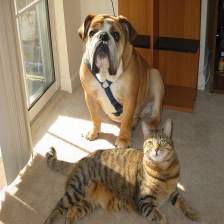

In [ ]:
Question1 = 'What animal'
Answer1 = ['dog','cat' ]
indices1 = [answer_to_index[ans] for ans in Answer1]# The indices of category 
img1 = Image.open('dog_cat.png')
img1

In [ ]:
dir_path = 'dog_cat.png' 
inputs = preprocess(dir_path, Question1)
ans = vqa_resnet(*inputs) # use model to predict the answer
answer_idx = np.argmax(F.softmax(ans, dim=1).data.numpy())
print(answer_words[answer_idx])

dog


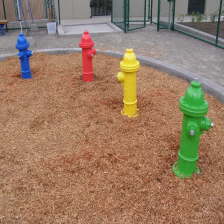

In [ ]:
Question2 = 'What color'
Answer2 = ['green','yellow' ]
indices2 = [answer_to_index[ans] for ans in Answer2]
img2 = Image.open('hydrant.png')
img2

In [ ]:
dir_path = 'hydrant.png' 
inputs = preprocess(dir_path, Question2)
ans = vqa_resnet(*inputs) # use model to predict the answer
answer_idx = np.argmax(F.softmax(ans, dim=1).data.numpy())
print(answer_words[answer_idx])

green


### Grad-CAM 
* **Overview:** Given an image with a question, and a category (‘dog’) as input, we foward propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (dog), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the two images. For each image, consider the answers we provided as the desired classes. Compare the heatmaps of different answers, and conclude. 


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully. 
 + The pretrained model `vqa_resnet` doesn't have the activation function after its last layer, the output is indeed the `raw class scores`, you can use it directly. Run "print(vqa_resnet)" to get more information on VGG model.
 + The last CNN layer of the model is: `vqa_resnet.resnet_layer4.r_model.layer4[2].conv3` 
 + The size of feature maps is 14x14, so as your heatmap. You need to project the heatmap to the original image(224x224) to have a better observation. The function `cv2.resize()` may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

<img src="./grad_cam.png">

A gradCAM function is introduced that orchestrates all of the behavior necessary to take the desired inputs, extract the gradients, generate the heatmap and, finally, output an image into Jupyter with the final result.

This function takes the question and file path of the source image as parameters, as well as the desired class index upon which the visualization will be based upon.

The flow of the function is as follows:

1. It defines gradCAMHook, a hook function that deals with the gradient extraction, heatmap generation and image output
2. It attaches this function with a hook to the final layer of the trained network
3. It foward feeds the question to the source image
4. It backpropagates using the class index
5. (Implicit) The hook is called during backpropagation, initiating the heatmap generation and the output of the Grad-CAM image.
6. The Hook is removed from the network in order to return the network to its original status

In [ ]:
import cv2

In [ ]:
def gradCAM(question, source_image, class_index):

    # GRADCAM STEP
    hk_output = None
    hk_grad_output = None

    # Setting up the hooks        
    def frontHook(self, input, output):
        # nonlocal makes so the variable writes on the gradCAM function scope
        nonlocal hk_output
        # Detaching to avoid requires_grad
        hk_output = output.detach()

    def backHook(self, grad_input, grad_output):
        nonlocal hk_grad_output
        hk_grad_output = grad_output[0].detach()

    fr_hook = vqa_resnet.resnet_layer4.r_model.layer4[2].conv3.register_forward_hook(frontHook)
    bk_hook = vqa_resnet.resnet_layer4.r_model.layer4[2].conv3.register_backward_hook(backHook)
    
    # Creating the query for the model
    inputs = preprocess(source_image, question)

    # Foward feeding the inputs -> will call the attached hook
    out = vqa_resnet(*inputs)

    # Backpropagating the output -> will call the attached hook
    vqa_resnet.zero_grad()
    out[:, class_index].backward()

    # From this point foward, the hk_* variables are set
    # The hooks are no longer necessary so we should remove them
    bk_hook.remove()
    fr_hook.remove()
    
    # Setting up equation (1) from pg. 4 of the paper
    weights = torch.mean(hk_grad_output, dim=[0, 2, 3])

    
    # Multiplying the activation (output) by the new weights
    for i in range(hk_grad_output.shape[1]):
        hk_output[:, i, :, :] *= weights[i]

    # Summing up as per equation (2) from pg. 5 of the paper
    gc_result = torch.mean(hk_output, dim=1).squeeze()

    # Relu wrapping up equation (2)
    gc_result = np.maximum(gc_result, 0)

    # Resizing the matrix from 14x14 to the image resolution 224x224
    heatmap = cv2.resize(gc_result.numpy(), (224, 224))

    # PRODUCING THE HEATMAP
    
    # Normalizing the heatmap
    heatmap = cv2.normalize(heatmap, heatmap, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # Applying a colormap to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * (255 - heatmap)), cv2.COLORMAP_JET)


    # Outputting final result
    # Loading the background image
    source_img = cv2.imread(source_image)

    # Overlaying both images
    final_image = heatmap * 0.5 + source_img * 0.5

    # A glitch in cv2.imshow crashes Jupyter
    # Converting so the image can be displayed using plt.imshow
    final_image = cv2.cvtColor(final_image.astype(np.uint8), cv2.COLOR_BGR2RGB)
    plt.imshow(final_image)

In [ ]:
# Recall originally for image 1
print(Answer1)
print(indices1)

['dog', 'cat']
[33, 30]


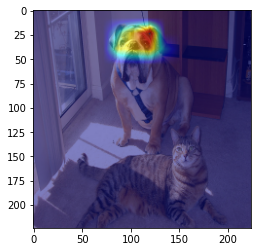

In [ ]:
question = 'What animal'
source_image = 'dog_cat.png'
class_index = answer_to_index['dog']

gradCAM(question, source_image, class_index)

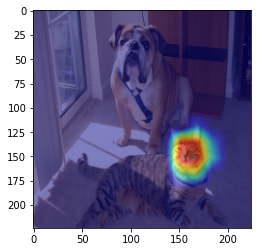

In [ ]:
question = 'What animal'
source_image = 'dog_cat.png'
class_index = answer_to_index['cat']

gradCAM(question, source_image, class_index)

On this example, we can clearly see that Grad-CAM correctly identifies both classes of cat and dog, focusing on their most distinctive characteristics, their faces.

Even if two actors are present in the image, the given class is enough for it to concern itself with only the desired agent.

In [ ]:
print(Answer2)
print(indices2)

['green', 'yellow']
[9, 11]


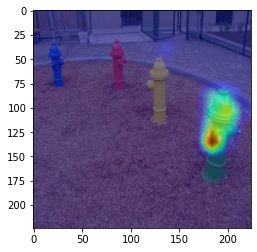

In [ ]:
question = 'What color'
source_image = 'hydrant.png'
class_index = answer_to_index['green']

gradCAM(question, source_image, class_index)

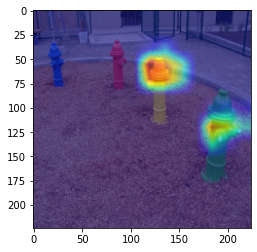

In [ ]:
question = 'What color'
source_image = 'hydrant.png'
class_index = answer_to_index['yellow']

gradCAM(question, source_image, class_index)

On this example, we see that while Grad-CAM was able to correctly detect the interest into the green hydrant, a mixed result was found for the yellow one.

When querying for yellow, the results focuses both on yellow and green, with a higher focus on the green one. While it is difficult to visualize for sure the exact reason for this behavior, two theories can be hypothesized:

1. The green hydrant is closer, making it bigger on the overall image. Since the original output was in 14x14 format, this could make the yellow hydrant too small on the convolution, while the green one just big enough to be noticed.

2. The reason why the green one would be noticed is that in RGB yellow is classified as (255, 255, 0). That is, yellow contains a full channel of green.

Both these theories in conjunction might explain, for example, why the blue hydrant wasn't been chosen (blue channel is 0 for yellow) and the red hydrant was not chosen as well (it is too far back in the image, probably causing issues in the 14x14 representation).

Overall, even with this small inconsistency, it is still very successful in detecting the color and the point of interest in this rather complex image.